# Using GAN to generate Monet-style images (Mini-Project)

## The Problem and Data

The goal of this project is to build a GAN (Generative Adversarial Network) model to generate Monet-styled images from casual photos. Specifically, CycleGAN model will be used.

According to the project page, **300** Monet paintings and **7028** photos with size 256x256 have been provided. The Monet paintings will be used to train the model, and the photos will be converted to Monet-style for submission.

## Environment Setup & EDA

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import keras, math, random, cv2, os

from keras.models import Sequential, Model
from keras.optimizers import Adam
from kaggle_datasets import KaggleDatasets

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + "/monet_tfrec/*.tfrec"))
print("Monet TFRecord Files:", len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + "/photo_tfrec/*.tfrec"))
print("Photo TFRecord Files:", len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
IMAGE_SIZE = (256, 256, 3)
BATCH_SIZE = 1

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCH_SIZE)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCH_SIZE)

According to the project page, the dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos. The `monet` directories contain 300 Monet paintings sized 256x256. The `photo` directories contain 7028 photos sized 256x256.

In [22]:
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

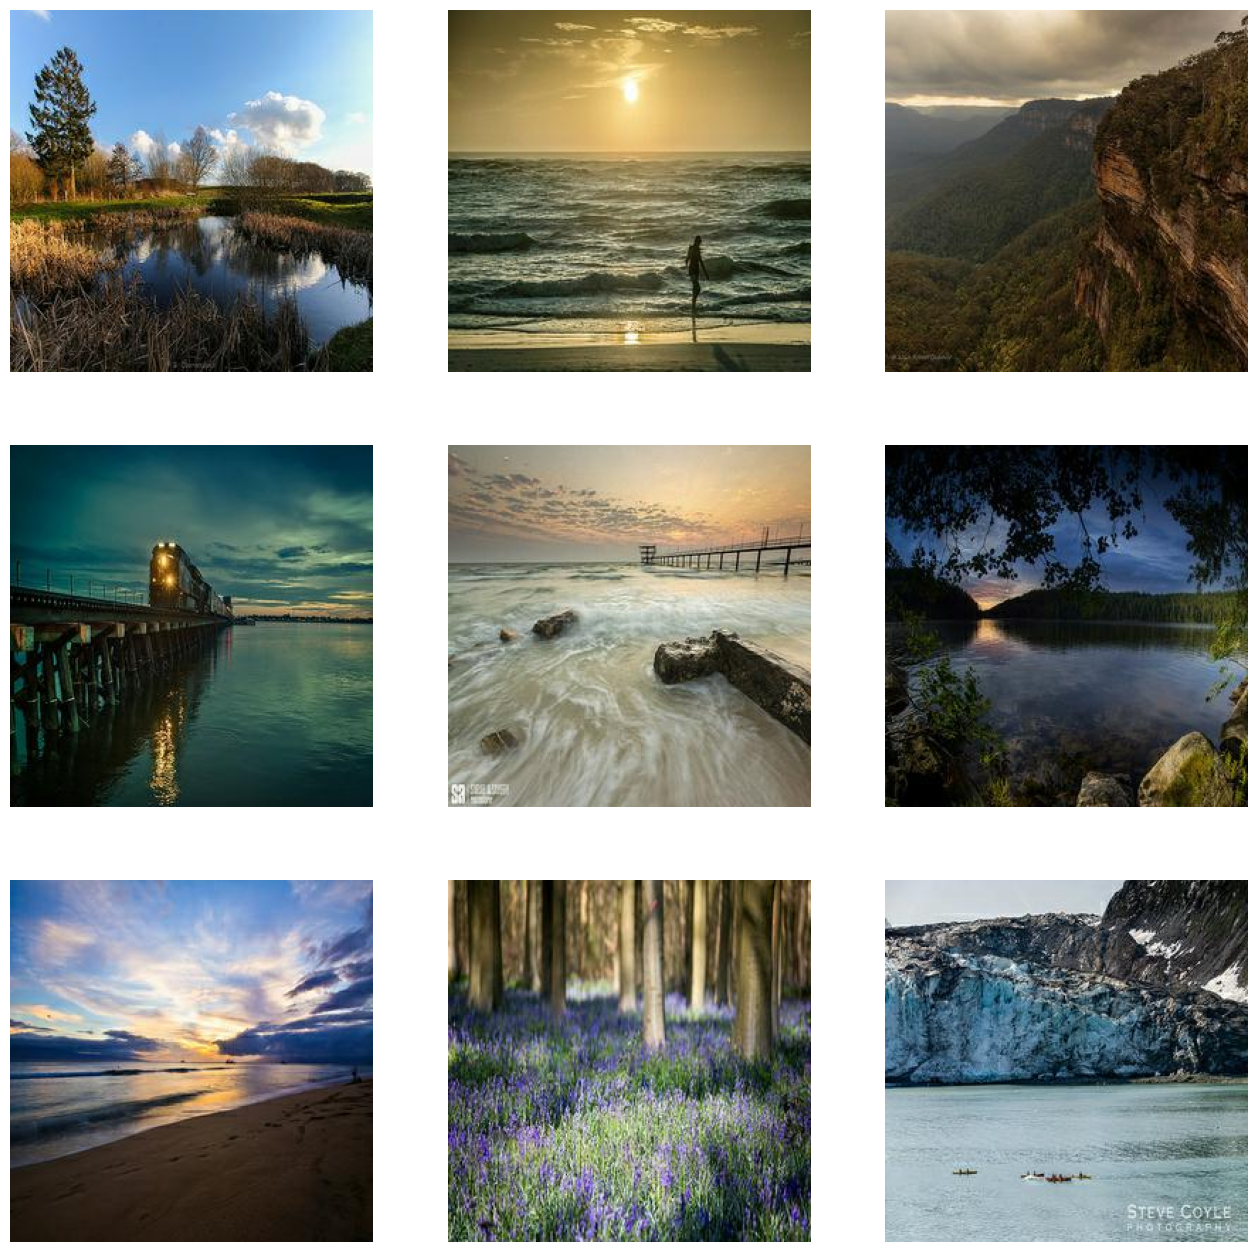

In [30]:
BASE_PATH = "../input/gan-getting-started/"
MONET_JPG_PATH = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_JPG_PATH = os.path.join(BASE_PATH, "photo_jpg")

batch_visualization(PHOTO_JPG_PATH, 9)

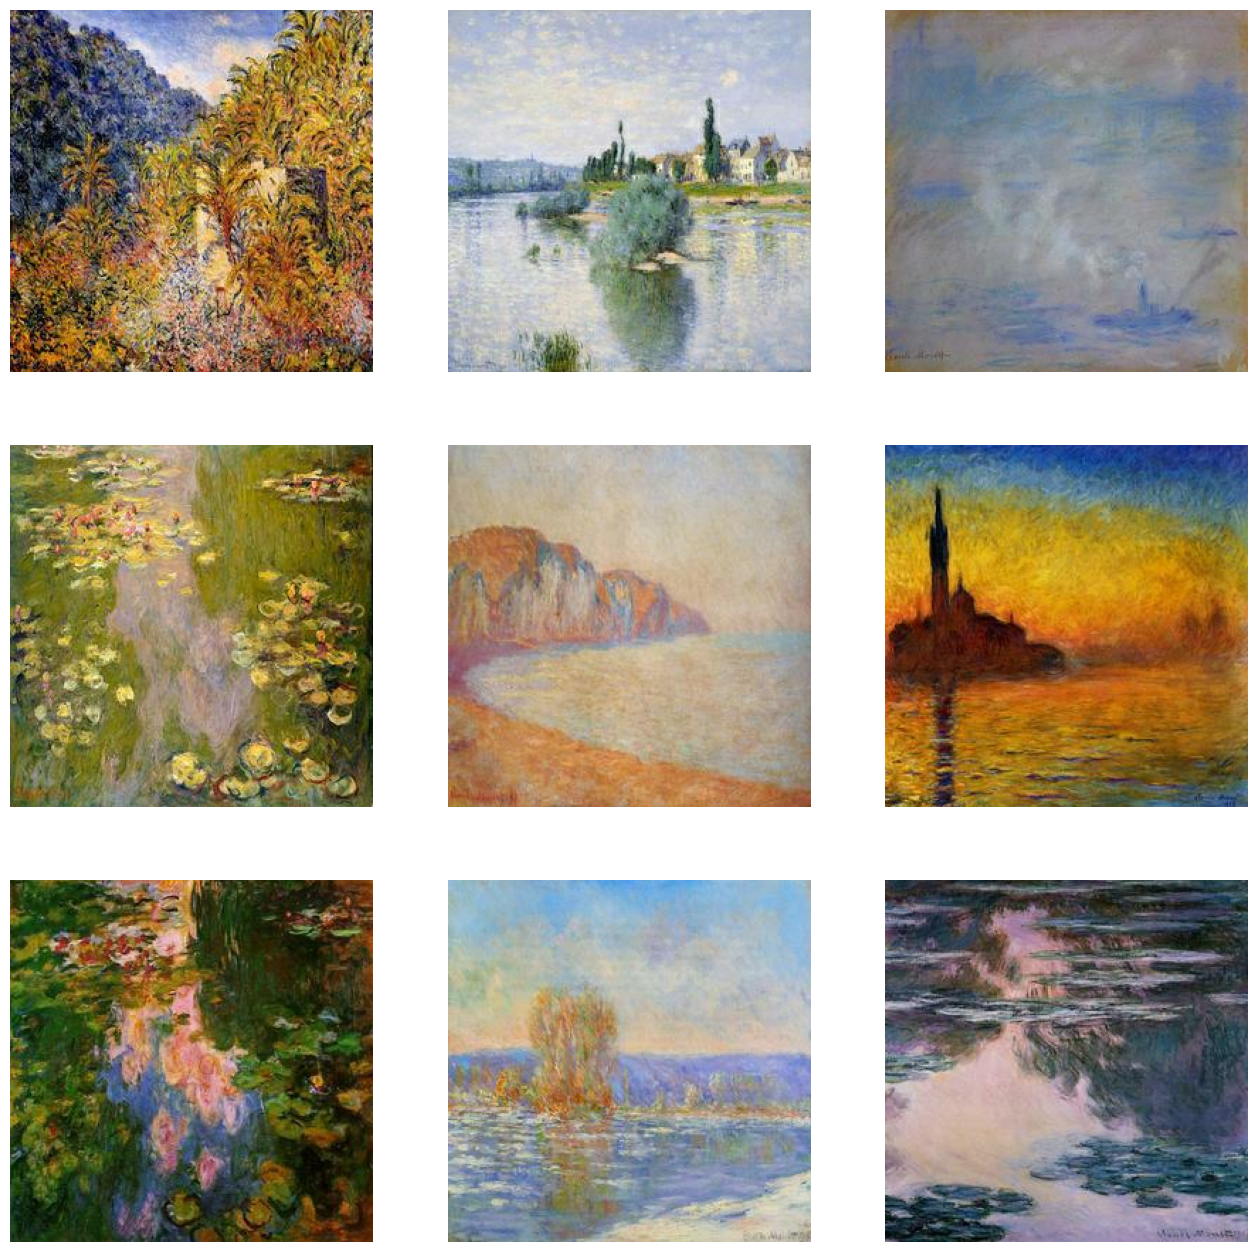

In [31]:
batch_visualization(MONET_JPG_PATH, 9)

## Model Building & Training

CycleGAN will be used here.

CycleGAN is a type of GAN that can learn to transform images from one domain to another without the need for paired training examples. This means that it can learn to convert, for example, a horse image to a zebra image, without needing a paired set of horse and zebra images. Instead, CycleGAN uses a cycle-consistency loss that enforces that the original image can be reconstructed from the transformed image, and vice versa. This helps to preserve the content of the original image while changing its style.

There will be two generators for photo-to-monet and monet-to-photo conversion. Also there will be two discriminators that discriminates generated photos and generated monets.

### Building blocks for the models

In [6]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def downsample(
    x,
    filters,
    activation,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Building the generators

In [7]:
def get_generator(
    filters=64,
    num_downsampling_blocks=3,
    num_upsample_blocks=3,
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init
):
    img_input = layers.Input(shape=IMAGE_SIZE)
    
    x = layers.Conv2D(filters, (6, 6), padding="same", kernel_initializer=kernel_initializer, use_bias=False)(img_input)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)
    
    # Downsampling blocks x 3
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))
        
    # Upsampling blocks x 3
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))
    
    # Final block
    x = layers.Conv2D(3, (6, 6), padding='same', use_bias=False)(x)
    x = layers.Activation("tanh")(x)
    
    model = keras.models.Model(img_input, x)
    
    return model

### Building the discriminators

In [8]:
def get_discriminator(
    filters=64,
    num_downsampling=3,
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
):
    img_input = layers.Input(shape=IMAGE_SIZE)
    
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    # Downsampling blocks x 3
    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x, 
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    # Final block
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same")(x)

    model = keras.models.Model(inputs=img_input, outputs=x)
    
    return model

### Building the CycleGAN model

In [9]:
gen_monet = get_generator()
gen_photo = get_generator()

disc_monet = get_discriminator()
disc_photo = get_discriminator()

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [10]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        gen_monet,
        gen_photo,
        disc_monet,
        disc_photo,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_monet = gen_monet
        self.gen_photo = gen_photo
        self.disc_monet = disc_monet
        self.disc_photo = disc_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_monet_opt,
        gen_photo_opt,
        disc_monet_opt,
        disc_photo_opt,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_monet_opt = gen_monet_opt
        self.gen_photo_opt = gen_photo_opt
        self.disc_monet_opt = disc_monet_opt
        self.disc_photo_opt = disc_photo_opt
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Real photo to fake monet 
            fake_monet = self.gen_monet(real_photo, training=True)
            # Real monet to fake photo
            fake_photo = self.gen_photo(real_monet, training=True)

            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_monet = self.gen_monet(fake_photo, training=True)
            # Cycle (Horse to fake zebra to fake horse) x -> y -> x
            cycled_photo = self.gen_photo(fake_monet, training=True)

            # Identity mapping
            same_monet = self.gen_monet(real_monet, training=True)
            same_photo = self.gen_photo(real_photo, training=True)

            # Discriminator output
            disc_real_monet = self.disc_monet(real_monet, training=True)
            disc_fake_monet = self.disc_monet(fake_monet, training=True)

            disc_real_photo = self.disc_photo(real_photo, training=True)
            disc_fake_photo = self.disc_photo(fake_photo, training=True)

            # Generator adverserial loss
            gen_monet_loss = self.generator_loss_fn(disc_fake_monet)
            gen_photo_loss = self.generator_loss_fn(disc_fake_photo)

            # Generator cycle loss
            cycle_loss_monet = self.cycle_loss_fn(real_monet, cycled_monet) * self.lambda_cycle
            cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo) * self.lambda_cycle

            # Generator identity loss
            id_loss_monet = (
                self.identity_loss_fn(real_monet, same_monet)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_photo = (
                self.identity_loss_fn(real_photo, same_photo)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_monet = gen_monet_loss + cycle_loss_monet + id_loss_monet
            total_loss_photo = gen_photo_loss + cycle_loss_photo + id_loss_photo

            # Discriminator loss
            disc_monet_loss = self.discriminator_loss_fn(disc_real_monet, disc_fake_monet)
            disc_photo_loss = self.discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Get the gradients for the generators
        grads_monet = tape.gradient(total_loss_monet, self.gen_monet.trainable_variables)
        grads_photo = tape.gradient(total_loss_photo, self.gen_photo.trainable_variables)

        # Get the gradients for the discriminators
        disc_monet_grads = tape.gradient(disc_monet_loss, self.disc_monet.trainable_variables)
        disc_photo_grads = tape.gradient(disc_photo_loss, self.disc_photo.trainable_variables)

        # Update the weights of the generators
        self.gen_monet_opt.apply_gradients(
            zip(grads_monet, self.gen_monet.trainable_variables)
        )
        self.gen_photo_opt.apply_gradients(
            zip(grads_photo, self.gen_photo.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_monet_opt.apply_gradients(
            zip(disc_monet_grads, self.disc_monet.trainable_variables)
        )
        self.disc_photo_opt.apply_gradients(
            zip(disc_photo_grads, self.disc_photo.trainable_variables)
        )

        return {
            "monet_loss": total_loss_monet,
            "photo_loss": total_loss_photo,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss,
        }

### Defining base loss functions

In [11]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

### Compiling & training the CycleGAN model

In [12]:
EPOCH_COUNT = 50

In [13]:
model_gan = CycleGAN(
    gen_monet=gen_monet, gen_photo=gen_photo, disc_monet=disc_monet, disc_photo=disc_photo
)

model_gan.compile(
    gen_monet_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_photo_opt=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_monet_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    disc_photo_opt=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

hist = model_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCH_COUNT,
    verbose=0
)

### Evaluating the CycleGAN model

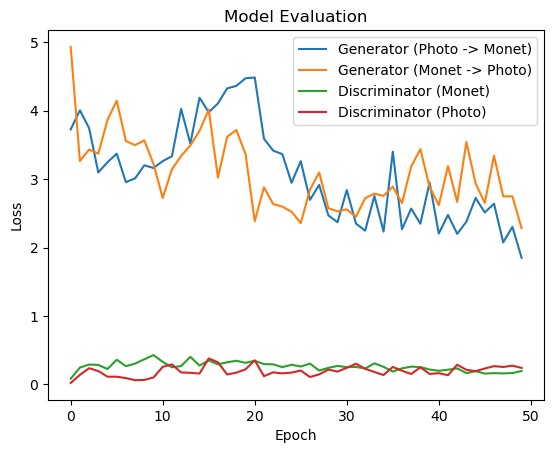

In [20]:
plt.plot(hist.history["monet_loss"])
plt.plot(hist.history["photo_loss"])
plt.plot(hist.history["disc_monet_loss"])
plt.plot(hist.history["disc_photo_loss"])

plt.title("Model Evaluation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Generator (Photo -> Monet)", "Generator (Monet -> Photo)", "Discriminator (Monet)", "Discriminator (Photo)"])

plt.show()

The loss of the generators shows a overall downward trend. Training with more epochs may produce better performance.

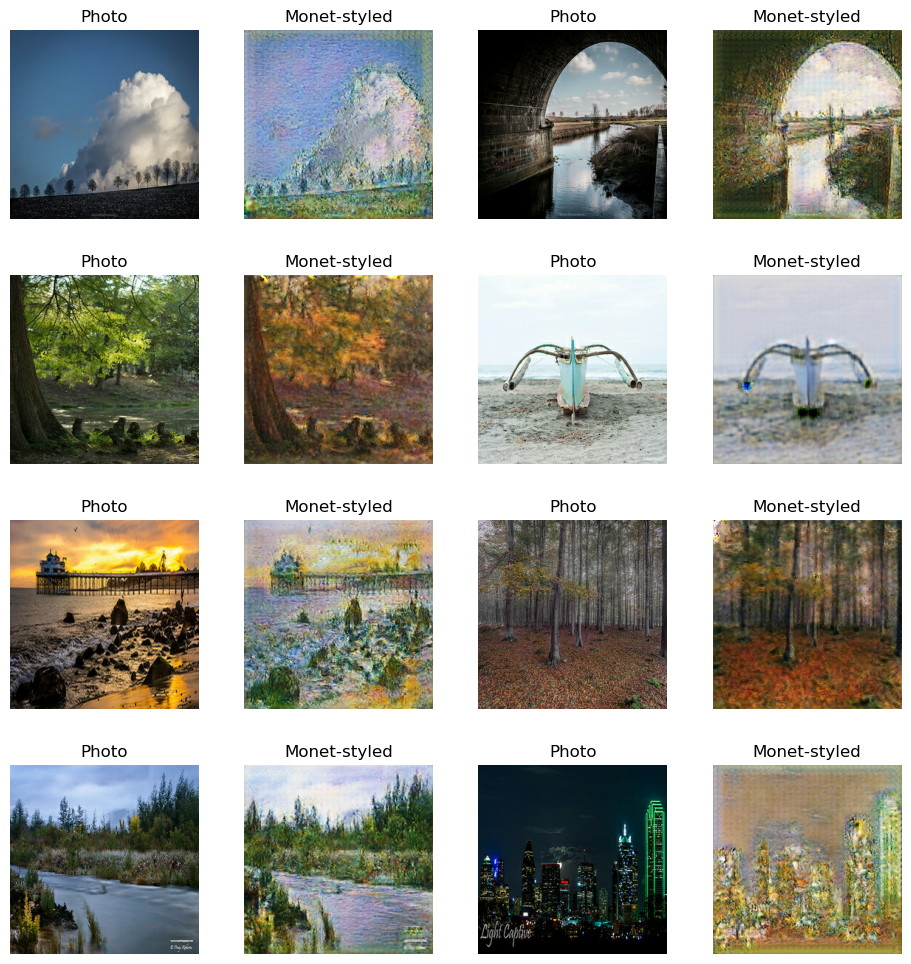

In [21]:
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, photo in enumerate(photo_ds.take(8)):
    monet = gen_monet(photo, training=False)[0].numpy()
    monet = (monet * 127.5 + 127.5).astype(np.uint8)
    photo = (photo[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    row, col = i // 2, i % 2

    axes[row, 2 * col].imshow(photo)
    axes[row, 2 * col].axis("off")
    axes[row, 2 * col].set_title("Photo")
    axes[row, 2 * col + 1].imshow(monet)
    axes[row, 2 * col + 1].axis("off")
    axes[row, 2 * col + 1].set_title("Monet-styled")
    
plt.subplots_adjust(wspace = 0.03, hspace = 0.3)

plt.show()

The result shows that the model successfully converted the photos to monet-style to some extent.

## Conclusion

The result demostrated the ability of CycleGAN to convert images. If time allows, we may try to train the model with more epochs and tune the model / hyperparameters for potential performance gain.

## Submission

In [16]:
! mkdir ../images

import PIL
import shutil

i = 1
for img in photo_ds:
    prediction = gen_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

'/kaggle/working/images.zip'

## References

GAN (CycleGAN) Image Translation - https://www.kaggle.com/code/keithrek/gan-cyclegan-image-translation

Monet - Visualization and Augmentation - https://www.kaggle.com/code/ihelon/monet-visualization-and-augmentation?scriptVersionId=48542122